# 1 The ProShares ETF Product

### 1. “Alternative ETFs”
Describe the two types of investments referenced by this term.
- alternative asset classes (giving
exposure to nonmainstream assets) and
- alternative strategies (pursuing investment
processes that were not constrained and could
use leverage, shorting, and derivatives).

### 2. Hedge Funds.

#### (a) Using just the information in the case, what are two measures by which hedge funds are an attractive investment?
- 

In [229]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.regression.rolling import RollingOLS
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

## 2 Analyzing the Data

#### Use the data found on Canvas, in ‘proshares analysis data.xlsx’. It has monthly data on financial indexes and ETFs from Aug 2011 through Sep 2021.

In [230]:
hf = pd.read_excel('proshares_analysis_data.xlsx', index_col=0, sheet_name='hedge_fund_series')
ml = pd.read_excel('proshares_analysis_data.xlsx', index_col=0, sheet_name='merrill_factors')
hf.index = pd.to_datetime(hf.index)
hf.head()

,HFRIFWI Index,MLEIFCTR Index,MLEIFCTX Index,HDG US Equity,QAI US Equity
2011-08-31,-0.032149,-0.025588,-0.025689,-0.027035,-0.006489
2011-09-30,-0.038903,-0.032414,-0.032593,-0.032465,-0.022144
2011-10-31,0.026858,0.043593,0.043320,0.050530,0.025241
2011-11-30,-0.013453,-0.012142,-0.012431,-0.028606,-0.007965
2011-12-31,-0.004479,0.001938,0.001796,0.012875,0.001823


In [231]:
def stats(df):
    mean = df.mean() * 12
    volatility = df.std() * np.sqrt(12)
    sharpe_ratio = mean/volatility
    return pd.DataFrame({'mean': mean, 'volatility': volatility, 'sharpe_ratio': sharpe_ratio})

In [232]:
def risk_stats(data, q):
    df = data.copy()
    df.index = data.index.date
    report = pd.DataFrame(columns = df.columns)
    
    report.loc['Skewness'] = df.skew()
    report.loc['Excess Kurtosis'] = df.kurtosis()
    report.loc['VaR (negated)'] = -df.quantile(q)
    report.loc['Expected Shortfall (negated)'] = -df[df < df.quantile(q)].mean()
    
    cum_ret = (1 + df).cumprod()
    rolling_max = cum_ret.cummax()
    drawdown = (cum_ret - rolling_max) / rolling_max
    report.loc['Max Drawdown'] = drawdown.min()
    report.loc['MDD Start'] = None
    report.loc['MDD End'] = drawdown.idxmin()
    report.loc['Recovery Date'] = None
    
    for col in df.columns:
        report.loc['MDD Start', col] = (rolling_max.loc[:report.loc['MDD End', col]])[col].idxmax()
        recovery_df = (drawdown.loc[report.loc['MDD End', col]:])[col]
        # modify the threshold for recovery from 0 to 0.001
        try:
            report.loc['Recovery Date', col] = recovery_df[recovery_df >= 0].index[0]

        except:
            report.loc['Recovery Date', col] = None
            report.loc['Recovery period (days)'] = None
    report.loc['Recovery period (days)'] = (report.loc['Recovery Date'] - report.loc['MDD Start']).dt.days
    return round(report,4)

In [233]:
def regression(df):
    reg_stats_df = pd.DataFrame(index = df.columns, columns = ['Beta', 'Treynor Ratio', 'Information Ratio'])
    for col in df.columns:
        if col == 'SPY':
            continue
        # Drop the NAs in y
        y = df[col].dropna()
        # Align the X with y 
        X = sm.add_constant(hf['SPY'].loc[y.index])
        reg = sm.OLS(y, X).fit()
        reg_stats_df.loc[col, 'Beta'] = reg.params[1]
        reg_stats_df.loc[col, 'Treynor Ratio'] = df[col].mean() * 12 / reg.params[1]
        reg_stats_df.loc[col, 'Information Ratio'] = (reg.params[0] / reg.resid.std()) * np.sqrt(12)
    return reg_stats_df[:-1]

### 2.1 For the series in the “hedge fund series” tab, report the following summary statistics:1
- (a) Mean
- (b) Volatility
- (c) Sharpe ratio Annualize these statistics.

In [234]:
hf['SPY'] = ml['SPY US Equity']

In [235]:
stats(hf)

,mean,volatility,sharpe_ratio
HFRIFWI Index,0.042867,0.060912,0.703758
MLEIFCTR Index,0.025665,0.056867,0.451308
MLEIFCTX Index,0.024278,0.056685,0.428294
HDG US Equity,0.014007,0.059239,0.236455
QAI US Equity,0.011576,0.048915,0.236649
SPY,0.121257,0.145613,0.832741


### 2.2 For the series in the “hedge fund series” tab, , calculate the following statistics related to tail- risk.
- (a) Skewness
- (b) Excess Kurtosis (in excess of 3)
- (c) VaR (.05) - the fifth quantile of historic returns
- (d) CVaR (.05) - the mean of the returns at or below the fifth quantile
- (e) Maximumdrawdown-include the dates of the max/min/recovery within the maxdrawdown period.

In [249]:
print('VaR and ES have been reported as positive as per Investopedia conventions')
risk_stats(hf, 0.05)


VaR and ES have been reported as positive as per Investopedia conventions


### 2.3 For the series in the “hedge fund series” tab, run a regression of each against SPY (found in the “merrill factors” tab.) Include an intercept. Report the following regression-based statistics:

- (a) Market Beta
- (b) Treynor Ratio
- (c) Information ratio
Annualize these three statistics as appropriate.

In [237]:
regression(hf)

,Beta,Treynor Ratio,Information Ratio
HFRIFWI Index,0.349957,0.122493,0.012954
MLEIFCTR Index,0.354876,0.07232,-0.731515
MLEIFCTX Index,0.353605,0.068658,-0.784565
HDG US Equity,0.363099,0.038577,-1.123684
QAI US Equity,0.291895,0.039657,-0.983817



### 2.4 Relative Performance
Discuss the previous statistics, and what they tell us about...
- (a) the differences between SPY and the hedge-fund series?
  - SPY has higher mean, vol and sharpe ratio as seen below compared to rest of HFs. SPY has the highest MDD compared to rest of the HFs.
- (b) which performs better between HDG and QAI.
  - QAI is better than HDG as it has higher Treynor and Information Ratios. Also QAI has lower VaR and CVaR numbers.
- (c) whether HDG and the ML series capture the most notable properties of HFRI.
  - HDG and ML dont capture the very high Kurtosis (6.16) and Skewness metrics of HFRI. Additionally, the sharpe (mean /vol) for HFRI is higher than ML and HDG.

In [238]:
stats(hf)

,mean,volatility,sharpe_ratio
HFRIFWI Index,0.042867,0.060912,0.703758
MLEIFCTR Index,0.025665,0.056867,0.451308
MLEIFCTX Index,0.024278,0.056685,0.428294
HDG US Equity,0.014007,0.059239,0.236455
QAI US Equity,0.011576,0.048915,0.236649
SPY,0.121257,0.145613,0.832741


### 2.5 Report the correlation matrix for these assets.
- (a) Show the correlations as a heat map.
- (b) Which series have the highest and lowest correlations?

<AxesSubplot:>

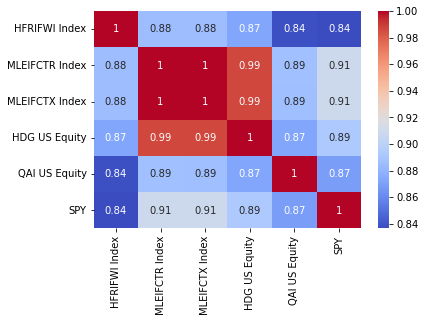

In [239]:
#correlation as heatmap
sns.heatmap(hf.corr(), annot=True, cmap='coolwarm')

In [240]:
from sympy import asec


correl = hf.corr()
print('The lowest correlation is between {} and {}'.format(correl.idxmin().values[0], correl.idxmin().index[0]))
for i in range(len(correl)):
    correl.iloc[i,i] = 0
    
corr_rank = correl.unstack().sort_values(ascending=False)

print('The highest correlation is between {} and {}'.format(corr_rank.index[0][0], corr_rank.index[0][1]))


The lowest correlation is between SPY and HFRIFWI Index
The highest correlation is between MLEIFCTR Index and MLEIFCTX Index


### 2.6 Replicate HFRI with the six factors listed on the “merrill factors” tab. Include a constant, and run the unrestricted regression

- (a) Report the intercept and betas.
  - See table below
- (b) Are the betas realistic position sizes, or do they require huge long-short positions?
  - The betas look realistic.
- (c) Report the R-squared.
  - 0.821 (from table)
- (d) Report the volatility of $ε^merr$, (the tracking error.)
  - 0.0257

In [241]:
y = hf['HFRIFWI Index']
X = sm.add_constant(ml)
reg = sm.OLS(y, X).fit()
print("Residuals std dev annuallized: ", reg.resid.std() * np.sqrt(12))
reg.summary()

Residuals std dev annuallized:  0.025750747622352327


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          HFRIFWI Index   R-squared:                       0.821
Model:                            OLS   Adj. R-squared:                  0.813
Method:                 Least Squares   F-statistic:                     97.27
Date:                Mon, 10 Oct 2022   Prob (F-statistic):           4.68e-45
Time:                        12:49:39   Log-Likelihood:                 467.20
No. Observations:                 134   AIC:                            -920.4
Df Residuals:                     127   BIC:                            -900.1
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0011      0.001      1.314      0.191      -0.001       0.003
SPY US Equity     0.0256      0.042      0.607      0.545      -0.058       0.109
USGG3M Index      0.8346      0.948      0.880      0.381      -1.042       2.711
EEM US Equity     0.0741      0.024      3.050      0.003       0.026       0.122
EFA US Equity     0.1056      0.041      2.585      0.011       0.025       0.186
EUO US Equity     0.0232      0.019      1.211      0.228      -0.015       0.061
IWM US Equity     0.1474      0.026      5.569      0.000       0.095       0.200
==============================================================================
Omnibus:                       19.616   Durbin-Watson:                   1.711
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               96.415
Skew:                           0.095   Prob(JB):                     1.16e-21
Kurtosis:                       7.151   Cond. No.                     1.44e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.44e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### 2.7 Let’s examine the replication out-of-sample.

<div>
<img src="screenshot.png" width="700"/>
</div>

In [242]:
model_60 = RollingOLS(y, X, window=60)
model_60_beta = model_60.fit().params.copy()
model_60.fit().params.tail(5)

,const,SPY US Equity,USGG3M Index,EEM US Equity,EFA US Equity,EUO US Equity,IWM US Equity
2022-05-31,0.004084,0.014981,-2.033076,0.108451,0.115181,0.033973,0.175357
2022-06-30,0.004204,0.011314,-2.009264,0.106422,0.111324,0.028605,0.181174
2022-07-31,0.004532,0.001035,-2.399443,0.118317,0.107350,0.020165,0.176503
2022-08-31,0.004210,-0.001067,-1.796845,0.128498,0.076688,0.018624,0.189947
2022-09-30,0.003941,-0.045773,-0.356888,0.086782,0.090389,0.005495,0.224953


In [243]:
#In-sample replication for t=61
is_replication = (model_60_beta * X).sum(axis=1, skipna=False)
out_replication = (model_60_beta.shift(1) * X).sum(axis=1, skipna=False)

rep_df = pd.DataFrame({'in_sample': is_replication, 'out_sample': out_replication, 'HFRIFWI Index': y, 'static':reg.fittedvalues})
rep_df.corr()

,in_sample,out_sample,HFRIFWI Index,static
in_sample,1.000000,0.993332,0.930242,0.990015
out_sample,0.993332,1.000000,0.887358,0.986613
HFRIFWI Index,0.930242,0.887358,1.000000,0.906244
static,0.990015,0.986613,0.906244,1.000000


<AxesSubplot:>

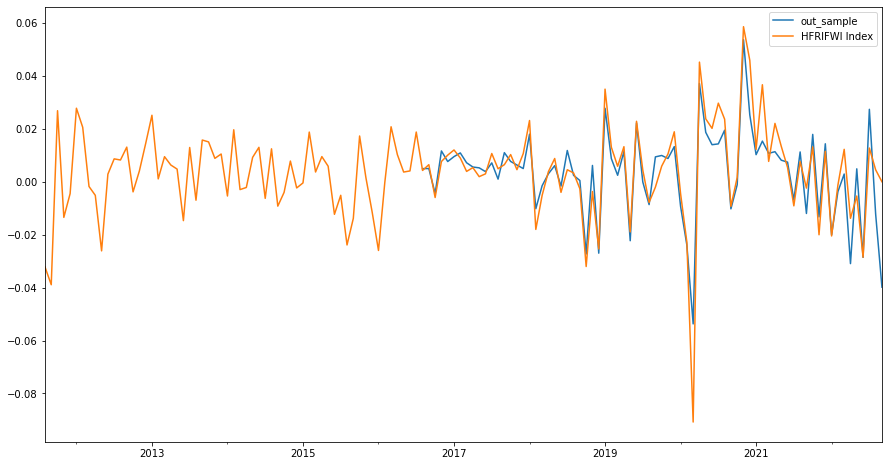

In [244]:
rep_df[['out_sample','HFRIFWI Index']].plot(figsize=(15,8))


### 2.7 How well does the out-of-sample replication perform with respect to the target?
- The out of sample is well correlated with the Index and seems to trace the target well.

### 2.8 We estimated the replications using an intercept. Try the full-sample estimation, but this time without an intercept.
Report
- (a) the regression beta. How does it compare to the estimated beta with an intercept $ \hat{\beta}^{merr} $
  - Beta in 3-month T-bills are quite high compared to the model with an intercept. Probably due to T-bill being the safest product in our list, they act as flat payoffs, i.e. an intercept.


In [245]:
y = hf['HFRIFWI Index']
X = ml
reg_no_int = sm.OLS(y, X).fit()
reg_no_int.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:          HFRIFWI Index   R-squared (uncentered):                   0.826
Model:                            OLS   Adj. R-squared (uncentered):              0.818
Method:                 Least Squares   F-statistic:                              101.3
Date:                Mon, 10 Oct 2022   Prob (F-statistic):                    3.55e-46
Time:                        12:49:39   Log-Likelihood:                          466.29
No. Observations:                 134   AIC:                                     -920.6
Df Residuals:                     128   BIC:                                     -903.2
Df Model:                           6                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
SPY US Equity     0.0404      0.041      0.993      0.323      -0.040       0.121
USGG3M Index      1.5517      0.778      1.995      0.048       0.013       3.091
EEM US Equity     0.0731      0.024      2.998      0.003       0.025       0.121
EFA US Equity     0.1008      0.041      2.470      0.015       0.020       0.181
EUO US Equity     0.0249      0.019      1.297      0.197      -0.013       0.063
IWM US Equity     0.1444      0.026      5.460      0.000       0.092       0.197
==============================================================================
Omnibus:                       17.937   Durbin-Watson:                   1.677
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               78.442
Skew:                           0.085   Prob(JB):                     9.26e-18
Kurtosis:                       6.744   Cond. No.                         110.
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [246]:
compare_beta = pd.DataFrame(data=reg_no_int.params, index=X.columns, columns=['no_intercept'])
compare_beta['with_intercept'] = reg.params[1:]
compare_beta

,no_intercept,with_intercept
SPY US Equity,0.040448,0.025589
USGG3M Index,1.551706,0.834569
EEM US Equity,0.073052,0.074135
EFA US Equity,0.100760,0.105604
EUO US Equity,0.024909,0.023240
IWM US Equity,0.144352,0.147375


- (b) the mean of the fitted value, $ \hat{r}^{hfri}_{t} $ . How does it compare to the mean of the HFRI?
  - Mean of the fitted values is less than the annuallized mean of HFRI. This is because the intercept is not present in the model.

In [247]:
print("HFRI Index annuallized mean is ",round(hf['HFRIFWI Index'].mean() * 12, 4))
print("fitted values annuallized mean is ",round(reg_no_int.fittedvalues.mean() * 12, 4))

HFRI Index annuallized mean is  0.0429
fitted values annuallized mean is  0.035


- (c) the correlations of the fitted values, $ \hat{r}^{hfri}_{t} $ to the HFRI. How does the correlation compare to that of the fitted values with an intercept?
  - The correlation is slightly lower than the in-sample model with an intercept. This is because the intercept is not present in this model.

In [248]:
rep_df['no_intercept'] = reg_no_int.fittedvalues
rep_df.corr()

,in_sample,out_sample,HFRIFWI Index,static,no_intercept
in_sample,1.000000,0.993332,0.930242,0.990015,0.987919
out_sample,0.993332,1.000000,0.887358,0.986613,0.984103
HFRIFWI Index,0.930242,0.887358,1.000000,0.906244,0.905696
static,0.990015,0.986613,0.906244,1.000000,0.999395
no_intercept,0.987919,0.984103,0.905696,0.999395,1.000000


### Do you think Merrill and ProShares fit their replicators with an intercept or not?
- We think that Merrill and Proshares are not fitting their replicators with an intercept, as these replicators are ETFs trying to deliver the same returns as HF index. Having said that an intercept wouldn't be appropriate as the returns need to match that of the HF index and not have a spread.
- If we were trying to hedge two portfolios, like for example a call option using a short position on the stock, then a spread in the returns would be acceptable since it can we covered using a constant yield instrument.